In [ ]:
"""
Title: Fast Training CIFAR-10 Model
Base model: ResNet-9
Author: Junu Kwon, Seoul National University
Contact: junukwon7@snu.ac.kr
Date: 2022-12-15
Description:
    This is a model for CIFAR-10 dataset.
    The model was trained for 4 epochs.
    The model was trained and tested on Google Colab.
Results within 10 trials:
    Best top-1 ACCURACY: 81.32%
    Average top-1 ACCURACY: 78.81%
    Train time: 1048.62s < 1200s
Hyperparameters:
    Learning rate: [0.06, 0.15, 0.2, 0.05]
    Batch size: 125
    Number of workers: 1
    Number of epochs: 4
    Batch normalization momentum: 0.4
    Label smoothing: 0.05
    Weight decay: 1e-4
    Activation: ReLU
    Optimizer: Adagrad
    Loss: CrossEntropyLoss
    See tune() for more details on tuning hyperparameters.
"""

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
[TOTAL 1048.4s] [TRAIN 1038.2s] ACC: [53.22, 65.32, 74.57, 81.32]


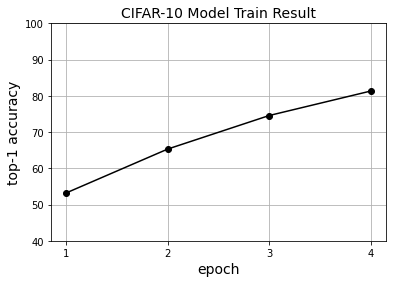

1048.6163747310638


In [ ]:
# Time
import time
t_start_time = time.time()

# Dependencies
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# Device: .to(cpu) might lead to performance loss
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Golbal hyperparameters
num_epochs = 4
batch_size = 125
num_workers = 1

# Image preprocessing modules
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data',
                                            train=True, 
                                            transform=transform,
                                            download=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data',
                                            train=False, 
                                            transform=transform,
                                            download=True)

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                            batch_size=batch_size,
                                            num_workers=num_workers,
                                            shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                            batch_size=batch_size,
                                            num_workers=num_workers, 
                                            shuffle=False)
test_size = len(test_loader.dataset)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, bn_momentum=0, downsample=None, activation=nn.ReLU(inplace=True)):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels, momentum=bn_momentum)
        self.activation = activation
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels, momentum=bn_momentum)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.activation(out)
        return out

# Model
class Model(nn.Module):
    def __init__(self, list_blocks, num_classes, bn_momentum, activation=nn.ReLU(inplace=True)):
        super(Model, self).__init__()
        self.in_channels = 16
        self.conv = nn.Conv2d(3, self.in_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn_momentum = bn_momentum
        self.bn = nn.BatchNorm2d(16, momentum=self.bn_momentum)
        self.activation = activation
        self.layer1 = self.get_layer(16, list_blocks[0], 1)
        self.layer2 = self.get_layer(32, list_blocks[1], 2)
        self.layer3 = self.get_layer(64, list_blocks[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def get_layer(self, out_channels, num_blocks, stride):
        downsample = None
        layers = []
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
                nn.BatchNorm2d(out_channels, momentum=self.bn_momentum))
        layers.append(ResidualBlock(self.in_channels, out_channels, stride, self.bn_momentum, downsample))
        self.in_channels = out_channels
        for i in range(num_blocks - 1):
            layers.append(ResidualBlock(out_channels, out_channels, 1, self.bn_momentum, None))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.activation(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# Learning curve plotting
def plot_graph(num_epochs, top1_list):
    import matplotlib.pyplot as plt
    epochs = [i+1 for i in range(num_epochs)]
    
    plt.plot(epochs, top1_list, color='black', marker='o')
    plt.title('CIFAR-10 Model Train Result', fontsize=14)
    plt.xlabel('epoch', fontsize=14)
    plt.ylabel('top-1 accuracy', fontsize=14)
    plt.xticks(epochs)
    plt.yticks([i for i in range(40, 101, 10)])
    plt.grid(True)
    plt.show()

# Train
def train(lr_list, bn_momentum, label_smoothing, weight_decay, activation=nn.ReLU(inplace=True)):
    t_train_start = time.time()
    model = Model(list_blocks=[2, 1, 2], num_classes=10, bn_momentum=bn_momentum, activation=activation)
    # model = Model(list_blocks=[2, 1, 2], num_classes=10, bn_momentum=bn_momentum, activation=activation).to(device) # GPU

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
    optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01, weight_decay=weight_decay)

    # One epoch
    top1_list = []
    for epoch in range(num_epochs):
        t_epoch_start = time.time()

        # Manual LR scheduler
        curr_lr = lr_list[epoch]
        for param in optimizer.param_groups:
            param['lr'] = curr_lr
        
        for i, (images, labels) in enumerate(train_loader):
            # images, labels = images.to(device), labels.to(device) # GPU

            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        t_test_start = time.time()
        with torch.no_grad():
            correct = 0

            for images, labels in test_loader:
                # images, labels = images.to(device), labels.to(device) # GPU

                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()
                
            top1_list.append(100 * correct / test_size)
     
    print(f"[TOTAL {time.time() - t_start_time:.1f}s] [TRAIN {time.time() - t_train_start:.1f}s] ACC: {top1_list}")
    return top1_list

top1_list = train([0.06, 0.15, 0.2, 0.05], 0.4, 0.05, 1e-4, nn.ReLU(inplace=True))
plot_graph(num_epochs, top1_list)

print(time.time() - t_start_time)

In [ ]:
"""
Hyperparameter tuning:
    1. Learning rate
    2. Batch normalization momentum
    3. Label smoothing
    4. Weight decay
    5. Activation function
Repeat 100 times, and then manual inspection + further tuning
Performed with Nvidia RTX 3070ti (8GB) GPU
"""

def tune():
    import random
    for _ in range(100):
            lr_list = [random.uniform(0.01, 0.3) for lr in range(num_epochs)]
            bn_momentum = random.uniform(0.1, 0.9)
            label_smoothing = random.uniform(0.01, 0.1)
            weight_decay = random.uniform(1e-5, 1e-3)
            for x in range(5):
                top1_list = train(lr_list, bn_momentum, label_smoothing, weight_decay, nn.ReLU(inplace=True)) # or nn.CELU(inplace=True, alpha=0.1)
                plot_graph(num_epochs, top1_list)